# GASP – A Genetic Algorithm for State Preparation

In [1]:
import pennylane.numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import pennylane as qml
import random
import copy

In [2]:
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

# psi_target = np.array([1, 0, 0, 1])/np.sqrt(2) # |00> + |11> - bell state
# psi_target = np.array([1, 0, 0, -1])/np.sqrt(2) # |00> - |11> - bell state

# psi_target = np.array([1, 0, 0, 0, 0, 0, 0, 1])/np.sqrt(2) # |000> + |111> - bell state

psi_target = np.array([0, 1, 1, 0, 1, 0, 0, 0])/np.sqrt(3) # W state




psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

In [3]:
def select_random_gate(basis_gates):
    gate = random.sample(basis_gates, 1)[0]
    if gate == qml.CNOT:
        return gate(wires=random.sample(range(n_qubits), 2))
    else:
        return gate(2*np.pi*random.random(), wires=random.sample(range(n_qubits),1))

def generate_random_circuit(n_gates):
    gates_list = []
    for i in range(n_gates):
        gates_list.append(select_random_gate(basis_gates))
    return gates_list

@qml.qnode(dev)
def circuit_from_list(gates_list):
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()


def inner_product(state1, state2):
    return np.abs(np.matmul(
        np.conjugate(np.transpose(state1)), 
        state2
    ))**2

In [4]:
def compute_fitness(input, psi_target):
    individuals = copy.deepcopy(input) # input is a list of individuals
    fitness_arr = []
    for i in individuals:
        fitness = inner_product(psi_target, circuit_from_list(i))
        fitness_arr.append(fitness)
    return fitness_arr

In [5]:
def population_crossover(input):
    """
    For now, multiplicity is 2. Population doubles after crossover.
    """
    individuals = copy.deepcopy(input) # input is the list of all individuals
    new_individuals = []
    for i in range(len(individuals)-1):
        temp_ind = crossover(individuals[i], individuals[i+1])
        new_individuals.append(temp_ind[0])
        new_individuals.append(temp_ind[1])

    temp_ind = crossover(individuals[-1], individuals[0])
    new_individuals.append(temp_ind[0])
    new_individuals.append(temp_ind[1])
    
    return new_individuals


def crossover(individual1, individual2):
    cutoff = int(np.floor(len(individual1)/2))
    new_ind1 = individual1[0:cutoff] +  individual2[cutoff:]
    new_ind2 = individual2[0:cutoff] + individual1[cutoff:]
    return new_ind1, new_ind2

def population_mutation(input, p=0.05):
    individuals_list = copy.deepcopy(input) # input is the list of all individuals
    new_individuals = []
    for i in individuals_list:
        new_individuals.append(mutation(i, p=p))
    return new_individuals


def mutation(individual, p):
    random_arr = np.random.rand(len(individual)) - p
    for i in range(len(individual)):
        if random_arr[i] < 0:
            individual = mutate(individual, i)
    return individual

def mutate(individual, pos):
    if individual[pos].name == "CNOT":
        individual[pos] = qml.CNOT(wires=[individual[pos].wires[1], individual[pos].wires[0]])
    else:
        individual[pos] = select_random_gate(basis_gates2)
    return individual

In [6]:
def update_circuit(individual, params, positions):
    updated_individual = []
    for i in range(len(params)):
        if positions[i] == 0: #CNOT
            updated_individual.append(qml.CNOT(wires=individual[i].wires))
        elif positions[i] == 1: #RX
            updated_individual.append(qml.RX(params[i], wires=individual[i].wires))
        elif positions[i] == 2: #RY
            updated_individual.append(qml.RY(params[i], wires=individual[i].wires))
        elif positions[i] == 3: #RZ
            updated_individual.append(qml.RZ(params[i], wires=individual[i].wires))
    return updated_individual

def optimize_circuit(individual, psi_target):
    # collect parameters from circuit
    params = [0]*len(individual)
    positions = [0]*len(individual)
    for i in range(len(individual)):
        if individual[i].name != "CNOT":
            params[i] = individual[i].parameters[0]
            if individual[i].name == "RX":
                positions[i] = 1
            elif individual[i].name == "RY":
                positions[i] = 2
            elif individual[i].name == "RZ":
                positions[i] = 3
    
    params = np.array(params, requires_grad=True)
    # print(f"Params = {params}")
    # print(f"Positions = {positions}")

    @qml.qnode(dev)
    def circuit(params):
        for i in range(len(params)):
            if positions[i] == 0: #CNOT
                qml.CNOT(wires=individual[i].wires)
            elif positions[i] == 1: #RX
                qml.RX(params[i], wires=individual[i].wires)
            elif positions[i] == 2: #RY
                qml.RY(params[i], wires=individual[i].wires)
            elif positions[i] == 3: #RZ
                qml.RZ(params[i], wires=individual[i].wires)

        return qml.state()

                
    def cost(params):
        state = circuit(params)
        fitness = inner_product(psi_target, state)
        return 1 - fitness


    # qml.draw_mpl(circuit)(params)

    opt = qml.AdamOptimizer(0.5)
    for i in range(100):
        params, prev_cost = opt.step_and_cost(cost, params)
        if i%99==0:
            print(f'Step: {i} ,Cost: {prev_cost}') 
    
    # print(f"Final params = {params}")
    # rebuild circuit

    optimized_individual = update_circuit(individual, params, positions)


    # qml.draw_mpl(circuit)(params)

    return optimized_individual


def population_optimization(individuals, psi_target):
    optimized_individuals = []
    individuals_copy = copy.deepcopy(individuals)
    for i in individuals_copy:
        optimized_individuals.append(optimize_circuit(i, psi_target))
    return optimized_individuals


In [7]:
def add_gate(individual):
    new_gate = generate_random_circuit(1)
    return individual + new_gate

def population_add_gate(individuals):
    new_individuals = [add_gate(i) for i in individuals]
    return new_individuals

In [8]:
MAX_GATES = 13
MAX_ITER = 25

finished_flag = False


n = 20 # number of individuals in each generation
n_gates = 9 # Inital number of gates
n_gates_intial = 9

individuals = [] # List of randomly generated initial individuals
for i in range(n):
    print(f"Generating circuit {i}")
    individuals.append(generate_random_circuit(n_gates))

final_result = []

print("Starting Genetic algorithm")
while n_gates < MAX_GATES:
    print(f"Starting with gates {n_gates}")

    if n_gates != n_gates_intial:
        individuals = population_add_gate(individuals)

    n_iter = 1

    while n_iter < MAX_ITER:

        print(f"Iteration {n_iter} starting ...")


        fitnesses = compute_fitness(individuals, psi_target)
        # TODO - Assess fitness and check for termination
        for i, fit in enumerate(fitnesses):
            if fit >= 0.95:
                finished_flag = True
                final_result.append(individuals[i])
                print("Found solution!!!")
                print(f"Fitness = {fit}")

        if finished_flag:
            break

        # Crossover
        crossover_individuals = population_crossover(individuals)

        # Mutation of population
        mutated_individuals = population_mutation(crossover_individuals, p=0.2)

        # Angle optimization
        print("Starting optimization")
        optimized_individuals = population_optimization(mutated_individuals, psi_target)
        print("Finished optimization")


        # compute fitness and selection
        fitnesses_before_selection = compute_fitness(optimized_individuals, psi_target)

        sorted_indices = np.argsort(fitnesses_before_selection)

        # updating individuals
        individuals = [optimized_individuals[i] for i in sorted_indices[-n:]] 

        n_iter += 1

    
    if finished_flag:
        break

    # increasing the number of gates after MAX_ITER  
    n_gates += 1
    print(f"Increasing number of gates to {n_gates}")


Generating circuit 0
Generating circuit 1
Generating circuit 2
Generating circuit 3
Generating circuit 4
Generating circuit 5
Generating circuit 6
Generating circuit 7
Generating circuit 8
Generating circuit 9
Starting Genetic algorithm
Starting with gates 8
Iteration 1 starting ...
Starting optimization
Step: 0 ,Cost: 0.9602502033882888
Step: 99 ,Cost: 0.3333452537067304
Step: 0 ,Cost: 1.0
Step: 99 ,Cost: 1.0
Step: 0 ,Cost: 0.9672737166551009
Step: 99 ,Cost: 0.666671223515779
Step: 0 ,Cost: 0.7869985467482574
Step: 99 ,Cost: 0.3333400004470467
Step: 0 ,Cost: 0.9648469691359365
Step: 99 ,Cost: 0.5555584048600256
Step: 0 ,Cost: 0.8832586725061091
Step: 99 ,Cost: 0.6666691381854335
Step: 0 ,Cost: 0.7683321090156453
Step: 99 ,Cost: 0.6666669955965083
Step: 0 ,Cost: 0.907211568538329
Step: 99 ,Cost: 0.6666687533874057
Step: 0 ,Cost: 1.0
Step: 99 ,Cost: 1.0
Step: 0 ,Cost: 0.8895125785864788
Step: 99 ,Cost: 0.555557949799351
Step: 0 ,Cost: 0.7442973529870995
Step: 99 ,Cost: 0.666666785474323

0: ──RY(10.21)──────────────╭X──────────RY(2.36)────────────╭●─┤  State
1: ──RX(-3.14)──RZ(3.14)─╭X─╰●──────────RX(0.14)──RX(-0.14)─╰X─┤  State
2: ──RY(-5.05)──RZ(3.15)─╰●──RY(-0.00)─────────────────────────┤  State


/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: Ma

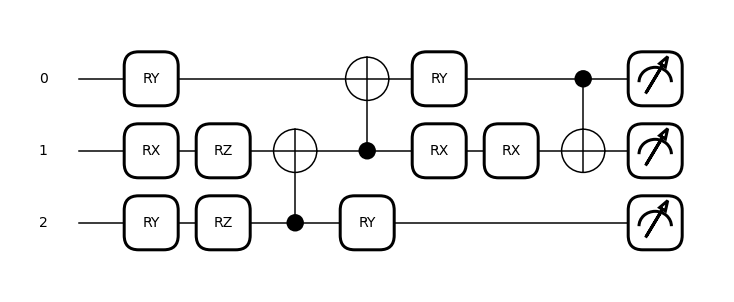

In [9]:
if finished_flag:
    print(qml.draw(circuit_from_list)(final_result[0]))
    qml.draw_mpl(circuit_from_list)(final_result[0])

In [12]:
def qml_to_qasm(circuit):
    for i in range(len(circuit)):
        if circuit[i].name == "CNOT":
            print(f"cx q[{circuit[i].wires[0]}], q[{circuit[i].wires[1]}];")
        elif circuit[i].name == "RX":
            print(f"rx({np.round(circuit[i].parameters[0],2)}) q[{circuit[i].wires[0]}];")
        elif circuit[i].name == "RY":
            print(f"ry({np.round(circuit[i].parameters[0],2)}) q[{circuit[i].wires[0]}];")
        elif circuit[i].name == "RZ":
            print(f"rz({np.round(circuit[i].parameters[0],2)}) q[{circuit[i].wires[0]}];")


In [13]:
qml_to_qasm(final_result[0])

ry(10.21) q[0];
ry(-5.05) q[2];
rx(-3.14) q[1];
rz(3.14) q[1];
rz(3.15) q[2];
cx q[2], q[1];
cx q[1], q[0];
rx(0.14) q[1];
rx(-0.14) q[1];
ry(2.36) q[0];
ry(-0.0) q[2];
cx q[0], q[1];


0: ──────────────╭X─┤  State
1: ───────────╭X─│──┤  State
2: ──RY(1.57)─╰●─╰●─┤  State


/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/ashutosh/miniforge3/lib/python3.9/_collections_abc.py:940: Ma

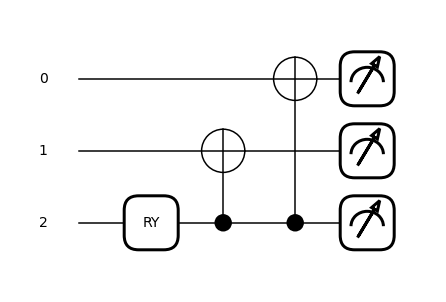

In [ ]:
if finished_flag:
    print(qml.draw(circuit_from_list)(final_result[1]))
    qml.draw_mpl(circuit_from_list)(final_result[1])

In [54]:
qml_to_qasm(final_result[1])

ry(1.57) q[2];
cx q[2], q[1];
cx q[2], q[0];
